In [73]:
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
import collections


In [74]:
def getGraphFromFile():
    graph = nx.read_edgelist('graph.txt', nodetype=int,
    data=(('weight',int),), create_using=nx.Graph())
    return graph

{(0, 1): Text(-0.3544361197442904, 0.33128257716277043, '10'),
 (0, 3): Text(0.2252284864934673, 0.4247868297385914, '10'),
 (1, 2): Text(-0.22522848649346722, -0.4247868297385914, '1'),
 (2, 3): Text(0.3544361197442905, -0.33128257716277043, '1')}

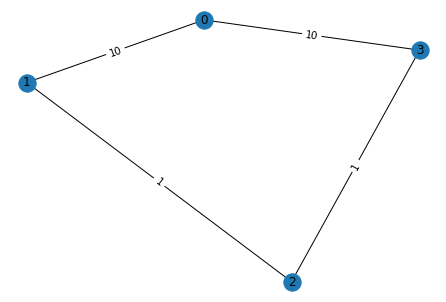

In [75]:
graph = getGraphFromFile()
pos = nx.spring_layout(graph)
nx.draw(graph,pos,with_labels=1)
labels = nx.get_edge_attributes(graph,'weight')
nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

In [76]:
qubitNumber = graph.number_of_edges()
layerNumber = 1
shotsNumber = 1000
device = qml.device("default.qubit", wires=qubitNumber, shots=shotsNumber)

In [77]:
def U_b(beta):
    for qubit in range(qubitNumber):
        qml.RX(2*beta, wires=qubit)

In [78]:
def U_c(gamma):
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        qml.CNOT(wires=[i,j])
        qml.RZ(weight*gamma, wires = j)
        qml.CNOT(wires=[i,j])

In [79]:
def compBasisMeasurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [80]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z, requires_grad=False)

@qml.qnode(device)
def circuit(gammas, betas, edge=None):

    for i in range(0,qubitNumber):
        qml.Hadamard(wires=i)

    for i in range(0,layerNumber):
        U_c(gammas[i])
        U_b(betas[i])

    if edge is None:
        return qml.sample(compBasisMeasurement(range(qubitNumber)))

    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

In [81]:
def costFunction(params):
    gammas = params[0]
    betas = params[1]
    cost = 0
    for i,j in graph.edges():
        weight = graph.get_edge_data(i,j)['weight']
        cost -= 0.5*weight*(1-circuit(gammas, betas, edge=[i,j]))
    return cost

In [82]:
def getMaxCutSolution(params):
    gammas = params[0]
    betas = params[1]
    outputDecimal = circuit(gammas, betas)
    occurrences = collections.Counter(outputDecimal)
    return occurrences

In [83]:
def getOptimizer(optimizerName="GradientDescent", stepSize=0.01):
    if optimizerName == "GradientDescent":
        return qml.GradientDescentOptimizer(stepsize=stepSize)
    if optimizerName == "Adam":
        return qml.AdamOptimizer(stepsize=stepSize)
    if optimizerName == "NesterovMomentum":
        return qml.NesterovMomentumOptimizer(stepsize=stepSize)
    if optimizerName == "Adagrad":
        return qml.AdagradOptimizer(stepsize=stepSize)

In [84]:
if __name__ == '__main__':
    params = 0.01*np.random.rand(2, layerNumber)
    optimizer = getOptimizer(optimizerName="Adam", stepSize=0.3)
    stepNumber = 200
    for i in range(stepNumber):
        params = optimizer.step(costFunction, params)
        print("Results in " + str(i) + " step: " + str(getMaxCutSolution(params)))
    print("Final results: " + str(getMaxCutSolution(params)))

 6.0: 79, 9.0: 72, 7.0: 35, 8.0: 25, 0.0: 17, 15.0: 14, 11.0: 13, 1.0: 13, 14.0: 8, 4.0: 6, 2.0: 1})
Results in 89 step: Counter({5.0: 260, 10.0: 242, 6.0: 88, 9.0: 88, 12.0: 85, 3.0: 81, 8.0: 40, 15.0: 33, 7.0: 29, 1.0: 16, 0.0: 14, 14.0: 13, 11.0: 9, 4.0: 2})
Results in 90 step: Counter({10.0: 277, 5.0: 264, 6.0: 94, 12.0: 81, 3.0: 66, 9.0: 61, 7.0: 30, 8.0: 28, 0.0: 20, 11.0: 16, 4.0: 15, 15.0: 14, 14.0: 11, 13.0: 9, 1.0: 8, 2.0: 6})
Results in 91 step: Counter({5.0: 275, 10.0: 261, 12.0: 84, 3.0: 76, 6.0: 67, 9.0: 67, 8.0: 28, 11.0: 21, 7.0: 21, 1.0: 19, 15.0: 19, 4.0: 15, 14.0: 13, 0.0: 12, 2.0: 12, 13.0: 10})
Results in 92 step: Counter({5.0: 273, 10.0: 269, 3.0: 79, 12.0: 78, 9.0: 70, 6.0: 56, 7.0: 39, 8.0: 27, 15.0: 21, 0.0: 19, 1.0: 18, 4.0: 18, 11.0: 15, 14.0: 11, 2.0: 4, 13.0: 3})
Results in 93 step: Counter({5.0: 285, 10.0: 244, 12.0: 97, 3.0: 83, 6.0: 79, 9.0: 69, 7.0: 34, 8.0: 29, 0.0: 22, 15.0: 16, 11.0: 16, 14.0: 12, 1.0: 8, 4.0: 6})
Results in 94 step: Counter({5.0: 28